Sample code for 1D Heisenberg model

In [1]:
import numpy as np # library for numerics
import scipy.linalg as la # library for linear algebra
import scipy.sparse.linalg as sla # library for sparse linear algebra
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, lil_matrix
import random as rd # library for random numbers
import matplotlib.pyplot as plt


# return parity of a 64bit integer m (by Andrew Shapira)
def parity(m):
        m ^= m>>1
        m ^= m>>2
        m = (m&0x1111111111111111) * 0x1111111111111111
        return (m>>60)&1


# initialize a complex vector[0:2**N-1]
def init_v(N):
        v = np.array([])
        for i in range(2**N):
                v = np.append(v,0.0+0.0j)
        return v

# initialize a complex random vector[0:2**N-1]
def rd_init_v(N):
        v = np.array([])
        norm = 0.0 + 0.0j
        for i in range(2**N):
                re = rd.random()
                im = rd.random()
                norm += re**2 + im**2
                v = np.append(v,re+im*1.0j)
        norm = np.sqrt(norm)
        return v/norm # normalized

Binary representaion for the spin at the $\ell$th site: $|1\rangle_{\ell} = |\uparrow\rangle_{\ell}$, $|0\rangle_{\ell} = |\downarrow\rangle_{\ell}$

$S=1/2$ spin operators acting on the $\ell$th site transform a wave function $c_1 |1\rangle_{\ell} + c_0|0\rangle_{\ell}$ as follows:

$\hat{S}^x_{\ell} \left(c_1 |1\rangle_{\ell} + c_0|0\rangle_{\ell} \right)=\frac{1}{2}c_0 |1\rangle_{\ell} + \frac{1}{2}c_1|0\rangle_{\ell}$, where $\hat{S}^x_{\ell}|1\rangle_{\ell} = +\frac{1}{2}|0\rangle_{\ell}$ and $\hat{S}^x_{\ell}|0\rangle_{\ell} = \frac{1}{2}|1\rangle_{\ell}$ 

$\hat{S}^y_{\ell} \left(c_1 |1\rangle_{\ell} + c_0|0\rangle_{\ell} \right)=-\frac{i}{2}c_0 |1\rangle_{\ell} + \frac{i}{2}c_1|0\rangle_{\ell}$, where $\hat{S}^y_{\ell}|1\rangle_{\ell} = +\frac{i}{2}|0\rangle_{\ell}$ and $\hat{S}^y_{\ell}|0\rangle_{\ell} = -\frac{i}{2}|1\rangle_{\ell}$ 



$\hat{S}^z_{\ell} \left(c_1 |1\rangle_{\ell} + c_0|0\rangle_{\ell} \right)=\frac{1}{2}c_0 |1\rangle_{\ell} - \frac{1}{2}c_1|0\rangle_{\ell}$, where $\hat{S}^z_{\ell}|1\rangle_{\ell} = +\frac{1}{2}|1\rangle_{\ell}$ and $\hat{S}^z_{\ell}|0\rangle_{\ell} = -\frac{1}{2}|0\rangle_{\ell}$ 

The ket vector representation is mapped to a 2 dimensional vector representation: $\hat{S}^y_{\ell}\left(c_1 |1\rangle_{\ell} + c_0|0\rangle_{\ell} \right)=-\frac{i}{2}c_0 |1\rangle_{\ell} + \frac{i}{2}c_1|0\rangle_{\ell} \rightarrow
S^{y}\left(\begin{array}{c}c_1\\c_0\\\end{array}\right)
=\frac{1}{2}\sigma^y \left(\begin{array}{c}c_1\\c_0\\\end{array}\right)$,
where the Pauli matrices: $\sigma^x=\left(\begin{array}{cc}0&1\\1&0\\\end{array}\right)$, 
$\sigma^y=\left(\begin{array}{cc}0&-i\\+i&0\\\end{array}\right)$, 
$\sigma^z=\left(\begin{array}{cc}+1&0\\0&-1\\\end{array}\right)$

In [17]:
# define spin operators for S=1/2
class spin_operators:
        # function returns j, c1 that satsfies S^x_ell c0|i> = c1|j>
        def SxI(self,ell,i,c0):
                icomb = 2**ell
                j = i^icomb
                return j, (0.5 + 0.0j)*c0
        # function returns j, c1 that satsfies S^y_ell c0|i> = c1|j>
        def SyI(self,ell,i,c0):
                icomb = 2**ell
                ibit  = i&icomb
                ibit  = parity(ibit) # obtain ellth bit (parity is not necessary)
                j = i^icomb
                return j, ((-1.0)**ibit) * (0.0 - 0.5j)*c0
        # function returns j, c1 that satsfies S^z_ell c0|i> = c1|j>
        def SzI(self,ell,i,c0):
                icomb = 2**ell
                ibit  = i&icomb
                ibit  = parity(ibit) # obtain ellth bit (parity is not necessary)
                return i, ((-1.0)**ibit) * (-0.5 + 0.0j)*c0

The following class defines a 1D Hamiltonian, $\hat{H}=J\sum_{i=0}^{L-1}
\left(
  \hat{S}^{x}_{{\rm mod}(i+1,L)}\hat{S}^{x}_{i}
  +
  \hat{S}^{y}_{{\rm mod}(i+1,L)}\hat{S}^{y}_{i}
  +
  \hat{S}^{z}_{{\rm mod}(i+1,L)}\hat{S}^{z}_{i}
\right)$:

In [18]:
# a class inherits from the class spin operators
class hamiltonian(spin_operators):
        # constructor for a L site 1D Heisenberg model with exchange coupling J
        def __init__(self,L,J):
                self.L = L
                self.J = J
        def param(self):
                print("L=",self.L,", J=",self.J)
        def multiply(self,v0,v1):
                for i in range(2**(self.L)):
                        c0 = v0[i]
                        # define 1D Heisenberg model
                        for j in range(self.L):
                                j1, c1 = self.SxI(j,i,c0)
                                j2, c2 = self.SxI((j+1)%self.L,j1,c1)
                                v1[j2] += J*c2
                                j1, c1 = self.SyI(j,i,c0)
                                j2, c2 = self.SyI((j+1)%self.L,j1,c1)
                                v1[j2] += J*c2
                                j1, c1 = self.SzI(j,i,c0)
                                j2, c2 = self.SzI((j+1)%self.L,j1,c1)
                                v1[j2] += J*c2

Set Hamiltonian parameters

In [27]:
L = 10
J = 1.0
ham = hamiltonian(L,J)
ham.param()

L= 10 , J= 1.0


Construct Hamiltonian matrix $H$ and fully diagonalize $H$. The lowest eigenvalue is printed. When $L\geq 12$, it tooks bit long.

In [28]:
H = np.zeros((2**L,2**L),dtype=np.complex)
for i in range(2**L):
        v0 = init_v(L)
        v1 = init_v(L)
        v0[i] = 1.0 + 0.0j
        ham.multiply(v0,v1)
        for j in range(2**L):
                H[j][i] = v1[j]
H_csr = csr_matrix(H)
#eig_vals,eig_vec = la.eig(H)
eig_vals,eig_vec = sla.eigs(H_csr) #疎行列形式に変換が必要
eig_id = np.argsort(eig_vals)
eig_vals = eig_vals[eig_id]
eig_vec = eig_vec[:,eig_id]
print(eig_vals[0:5].real)

[-4.51544635 -4.09220735 -4.09220735 -4.09220735 -3.77059744]


Please complete the Lanczos steps below.

Tips:
1. The inner product of v0 and v1 is given by np.dot(v0.conjugate(),v1).
2. The eigenvalues and eigenvectors of H_Ks[i,j] (0$\leq$i,j$\leq$m) is given through eig_vals,eig_vec = la.eig(H_Ks[0:m+1,0:m+1]).

In [30]:
N_lmax = 32 # upper limit of the number of the Lanczos step
v0 = init_v(L)
w  = init_v(L)
v1 = rd_init_v(L) # initial vector
beta = 0.0 + 0.0j
H_Ks = np.zeros((N_lmax+1,N_lmax+1),dtype=np.complex)
for m in range(N_lmax):
        w = -beta *  v0
        ham.multiply(v1,w) # w += H * v1
        alpha = np.dot(w.conjugate(),v1)
        w += -alpha * v1
        beta = np.sqrt(abs(np.dot(w.conjugate(),w)))
        v0 = v1
        v1 = w / beta
        H_Ks[m,m] = alpha
        H_Ks[m,m+1] = beta
        H_Ks[m+1,m] = beta
        eig_vals,eig_vec = la.eig(H_Ks[0:m+1,0:m+1])
        eig_id = np.argsort(eig_vals)
        eig_vals = eig_vals[eig_id]
        print(m,eig_vals[0].real)

0 1.8693657258559768
1 -1.269032469348084
2 -2.630932877140178
3 -3.4089109901931534
4 -3.8666897302340546
5 -4.142428405317837
6 -4.296711332006867
7 -4.395536748259165
8 -4.4570286226346765
9 -4.489070414467065
10 -4.50446436842019
11 -4.5119110467351735
12 -4.514383163703098
13 -4.515117496501205
14 -4.515349618002835
15 -4.515421744250787
16 -4.515440131921327
17 -4.515444756034324
18 -4.515446051560749
19 -4.515446307241909
20 -4.515446347425678
21 -4.515446353445261
22 -4.515446354357108
23 -4.515446354476274
24 -4.515446354490161
25 -4.515446354491836
26 -4.515446354492013
27 -4.51544635449205
28 -4.515446354492047
29 -4.5154463544920365
30 -4.51544635449205
31 -4.515446354492031


In [2]:
class helium4:

  def __init__(self,L,N,a1,a2):
    self.L = L # lnear length of cubic
    self.N = N # particle number
    self.a1 = a1 # variational parameter defines length scale
    self.a2 = a2 # power
    self.rcut = 0.5*a1 # cutoff for particle-particle distance
    self.config = np.zeros((N,3),dtype=np.float64)
    self.dist = np.zeros((N,N),dtype=np.float64)

  def function_u(self,r):
    if r > self.rcut:
      uofr = (self.a1/r)**self.a2
    else:
      uofr = (self.a1/self.rcut)**self.a2
    return uofr

  def initialize_config(self):
    for j in range(self.N):
      for i in range(3):
        self.config[j][i] = self.L * rd.random()
    for iupdate in range(self.N):
      self.update_dist(iupdate)

  def update_config(self,iupdate):
    d = 0.05*self.L
    for i in range(3):
      self.config[iupdate][i] += 2.0*d*(rd.random()-0.5)
      if self.config[iupdate][i] > self.L:
        self.config[iupdate][i] -= self.L
      elif self.config[iupdate][i] < 0.0:
        self.config[iupdate][i] += self.L

  def update_dist(self,iupdate):
    for j in range(self.N):
      tmp_dist = self.dist_periodic(he4.config[j],he4.config[iupdate]) 
      if tmp_dist > self.rcut:
        self.dist[j,iupdate] = tmp_dist
        self.dist[iupdate,j] = tmp_dist
      else:
        self.dist[j,iupdate] = self.rcut
        self.dist[iupdate,j] = self.rcut

  def dist_periodic(self,vec1,vec2):
    dist_old = np.sqrt(3.0)*self.L
    for iz in range(-1,2):
      for iy in range(-1,2):
        for ix in range(-1,2):
          tmp_dist = 0.0
          tmp_dist += ( self.L*ix + vec1[0] - vec2[0])**2
          tmp_dist += ( self.L*iy + vec1[1] - vec2[1])**2
          tmp_dist += ( self.L*iz + vec1[2] - vec2[2])**2
          tmp_dist = np.sqrt(tmp_dist)
          if tmp_dist < dist_old:
            dist_old = tmp_dist
          #print(self.L*ix,self.L*iy,self.L*iz,tmp_dist,dist_old)
    return dist_old

  def accum_Nrdr(self,Ndr,Nrdr):
    rmax = 0.5*self.L
    dr = rmax/Ndr
    for m in range(Ndr):
      r = rmax*(m + 0.5)/Ndr
      for i in range(self.N-1):
        for j in range(i+1,self.N):
          if self.dist[i][j] >= r - 0.5*dr and self.dist[i][j] < r + 0.5*dr:
            Nrdr[m] = Nrdr[m] + 1.0

  def calc_gofr(self,Nsample,Ndr,Nrdr,gofr,vecr):
    Omega = self.L**3
    rho = 1.0*self.N / Omega
    rmax = 0.5*self.L
    dr = rmax/Ndr
    for m in  range(Ndr):
      r = rmax*(m+0.5)/Ndr
      vecr[m] = r
      gofr[m] = Nrdr[m]/(2.0*Nsample*np.pi*rho*rho*Omega*r*r*dr)


Wup 0
Wup 10
Wup 20
Wup 30
Wup 40
Wup 50
Wup 60
Wup 70
Wup 80
Wup 90
Wup 100
Wup 110
Wup 120
Wup 130
Wup 140
Wup 150
Wup 160
Wup 170
Wup 180
Wup 190
Wup 200
Wup 210
Wup 220
Wup 230
Wup 240
Wup 250
Wup 260
Wup 270
Wup 280
Wup 290
Wup 300
Wup 310
Wup 320
Wup 330
Wup 340
Wup 350
Wup 360
Wup 370
Wup 380
Wup 390
MCstep 0
MCstep 10
MCstep 20
MCstep 30
MCstep 40
MCstep 50
MCstep 60
MCstep 70
MCstep 80
MCstep 90
MCstep 100
MCstep 110
MCstep 120
MCstep 130
MCstep 140
MCstep 150
MCstep 160
MCstep 170
MCstep 180
MCstep 190
MCstep 200
MCstep 210
MCstep 220
MCstep 230
MCstep 240
MCstep 250
MCstep 260
MCstep 270
MCstep 280
MCstep 290
MCstep 300
MCstep 310
MCstep 320
MCstep 330
MCstep 340
MCstep 350
MCstep 360
MCstep 370
MCstep 380
MCstep 390
MCstep 400
MCstep 410
MCstep 420
MCstep 430
MCstep 440
MCstep 450
MCstep 460
MCstep 470
MCstep 480
MCstep 490
MCstep 500
MCstep 510
MCstep 520
MCstep 530
MCstep 540
MCstep 550
MCstep 560
MCstep 570
MCstep 580
MCstep 590
MCstep 600
MCstep 610
MCstep 620
MCstep 63

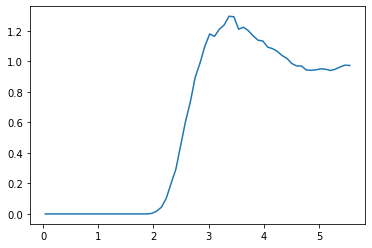

In [3]:
rd.seed(0)
he4 = helium4(11.2,32,2.6,5)
he4.initialize_config()
#print(he4.config)
#print(he4.dist)
#print(int(1.99))
#config_old = np.zeros((he4.N,3),dtype=np.float64)
#config_old[:][:] = he4.config[:][:]
#print(config_old)
#he4.update_config(0)
#print(config_old)
#print(he4.config)
Ndr = 64
Nrdr = np.zeros((Ndr),dtype=np.float64)
gofr = np.zeros((Ndr),dtype=np.float64)
vecr = np.zeros((Ndr),dtype=np.float64)
Nsample = 800
Nwup = 400
config_old = np.zeros((he4.N,3),dtype=np.float64)
dist_old = np.zeros((he4.N,he4.N),dtype=np.float64)
for i in range(Nwup):
  for j in range(he4.N):
    config_old[:][:] = he4.config[:][:]
    dist_old[:][:] = he4.dist[:][:]
    iupdate = rd.randrange(he4.N)
    he4.update_config(iupdate)
    he4.update_dist(iupdate)
    lnPNt = 0.0
    lnPNi = 0.0
    for m in range(he4.N):
      if m != iupdate:
        lnPNt -= 2.0*he4.function_u(he4.dist[m][iupdate])
        lnPNi -= 2.0*he4.function_u(dist_old[m][iupdate])
    #print(lnPNt,lnPNi)
    ratio = np.exp(lnPNt - lnPNi)
    if ratio <= rd.random():
      he4.config[:][:] = config_old[:][:]
      he4.dist[:][:] = dist_old[:][:]
  if i%10 == 0:
    print("Wup",i)

for i in range(Nsample):
  for j in range(he4.N):
    config_old[:][:] = he4.config[:][:]
    dist_old[:][:] = he4.dist[:][:]
    iupdate = rd.randrange(he4.N)
    he4.update_config(iupdate)
    he4.update_dist(iupdate)
    lnPNt = 0.0
    lnPNi = 0.0
    for m in range(he4.N):
      if m != iupdate:
        lnPNt -= 2.0*he4.function_u(he4.dist[m][iupdate])
        lnPNi -= 2.0*he4.function_u(dist_old[m][iupdate])
    #print(lnPNt,lnPNi)
    ratio = np.exp(lnPNt - lnPNi)
    if ratio <= rd.random():
      he4.config[:][:] = config_old[:][:]
      he4.dist[:][:] = dist_old[:][:]
  if i%10 == 0:
    print("MCstep",i)
  he4.accum_Nrdr(Ndr,Nrdr)
he4.calc_gofr(Nsample,Ndr,Nrdr,gofr,vecr)
plt.plot(vecr,gofr)